0


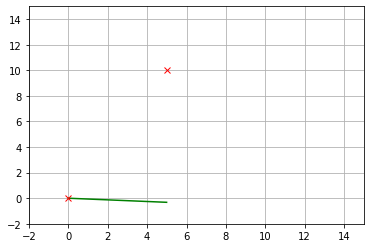

1


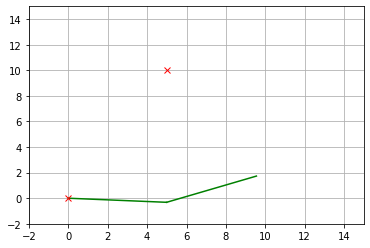

2


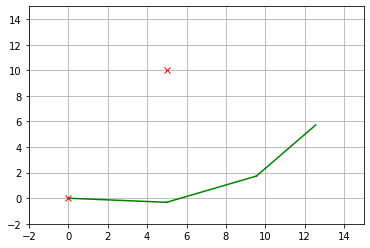

0


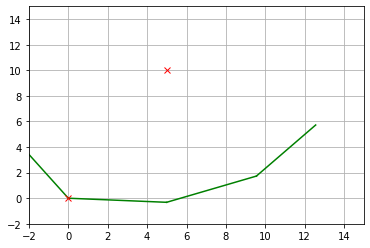

3


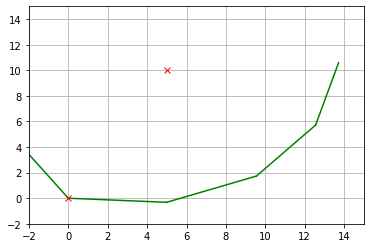

3
Goal!!


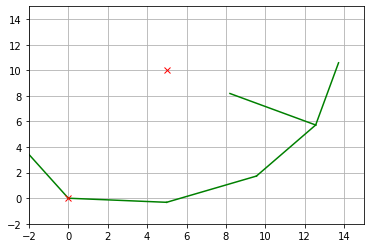

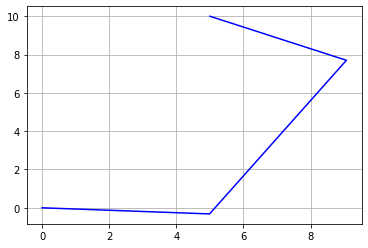

In [9]:
"""
Path Planning Sample Code with Randamized Rapidly-Exploring Random Trees (RRT)

@author: AtsushiSakai(@Atsushi_twi)

"""

import matplotlib.pyplot as plt
import random
import math
import copy

show_animation = True


class RRT():
    """
    Class for RRT Planning
    """

    def __init__(self, start, goal, obstacleList, randArea, expandDis=5.0, goalSampleRate=50, maxIter=500):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Ramdom Samping Area [min,max]

        """
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = randArea[0]
        self.maxrand = randArea[1]
        self.expandDis = expandDis
        self.goalSampleRate = goalSampleRate
        self.maxIter = maxIter
        self.obstacleList = obstacleList

    def Planning(self, animation=True):
        """
        Pathplanning

        animation: flag for animation on or off
        """

        self.nodeList = [self.start]
        while True:
            # Random Sampling
            if random.randint(0, 1000) > self.goalSampleRate:
                rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(
                    self.minrand, self.maxrand)]
            else:
                rnd = [self.end.x, self.end.y]

            # Find nearest node
            nind = self.GetNearestListIndex(self.nodeList, rnd)
            print(nind)

            # expand tree
            nearestNode = self.nodeList[nind]
            theta = math.atan2(rnd[1] - nearestNode.y, rnd[0] - nearestNode.x)

            newNode = copy.deepcopy(nearestNode)
            newNode.x += self.expandDis * math.cos(theta)
            newNode.y += self.expandDis * math.sin(theta)
            newNode.parent = nind

            if not self.__CollisionCheck(newNode, self.obstacleList):
                continue

            self.nodeList.append(newNode)

            # check goal
            dx = newNode.x - self.end.x
            dy = newNode.y - self.end.y
            d = math.sqrt(dx * dx + dy * dy)
            if d <= self.expandDis:
                print("Goal!!")
                break

            if animation:
                self.DrawGraph(rnd)

        path = [[self.end.x, self.end.y]]
        lastIndex = len(self.nodeList) - 1
        while self.nodeList[lastIndex].parent is not None:
            node = self.nodeList[lastIndex]
            path.append([node.x, node.y])
            lastIndex = node.parent
        path.append([self.start.x, self.start.y])

        return path

    def DrawGraph(self, rnd=None):
        plt.clf()
        if rnd is not None:
            plt.plot(rnd[0], rnd[1], "^k")
        for node in self.nodeList:
            if node.parent is not None:
                plt.plot([node.x, self.nodeList[node.parent].x], [
                         node.y, self.nodeList[node.parent].y], "-g")
        for (x, y, size) in self.obstacleList:
            self.PlotCircle(x, y, size)

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        plt.pause(0.01)

    def PlotCircle(self, x, y, size):
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(math.radians(d)) for d in deg]
        yl = [y + size * math.sin(math.radians(d)) for d in deg]
        plt.plot(xl, yl, "-k")

    def GetNearestListIndex(self, nodeList, rnd):
        dlist = [(node.x - rnd[0]) ** 2 + (node.y - rnd[1])
                 ** 2 for node in nodeList]
        minind = dlist.index(min(dlist))
        return minind

    def __CollisionCheck(self, node, obstacleList):

        for (ox, oy, size) in obstacleList:
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx * dx + dy * dy)
            if d <= size:
                return False  # collision

        return True  # safe


class Node():
    """
    RRT Node
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None


def GetPathLength(path):
    le = 0
    for i in range(len(path) - 1):
        dx = path[i + 1][0] - path[i][0]
        dy = path[i + 1][1] - path[i][1]
        d = math.sqrt(dx * dx + dy * dy)
        le += d

    return le


def GetTargetPoint(path, targetL):
    le = 0
    ti = 0
    lastPairLen = 0
    for i in range(len(path) - 1):
        dx = path[i + 1][0] - path[i][0]
        dy = path[i + 1][1] - path[i][1]
        d = math.sqrt(dx * dx + dy * dy)
        le += d
        if le >= targetL:
            ti = i - 1
            lastPairLen = d
            break

    partRatio = (le - targetL) / lastPairLen
    #  print(partRatio)
    #  print((ti,len(path),path[ti],path[ti+1]))

    x = path[ti][0] + (path[ti + 1][0] - path[ti][0]) * partRatio
    y = path[ti][1] + (path[ti + 1][1] - path[ti][1]) * partRatio
    #  print((x,y))

    return [x, y, ti]


def LineCollisionCheck(first, second, obstacleList):
    # Line Equation

    x1 = first[0]
    y1 = first[1]
    x2 = second[0]
    y2 = second[1]

    try:
        a = y2 - y1
        b = -(x2 - x1)
        c = y2 * (x2 - x1) - x2 * (y2 - y1)
    except ZeroDivisionError:
        return False

    for (ox, oy, size) in obstacleList:
        d = abs(a * ox + b * oy + c) / (math.sqrt(a * a + b * b))
        if d <= (size):
            return False

    #  print("OK")

    return True  # OK


def PathSmoothing(path, maxIter, obstacleList):
    #  print("PathSmoothing")

    le = GetPathLength(path)

    for i in range(maxIter):
        # Sample two points
        pickPoints = [random.uniform(0, le), random.uniform(0, le)]
        pickPoints.sort()
        #  print(pickPoints)
        first = GetTargetPoint(path, pickPoints[0])
        #  print(first)
        second = GetTargetPoint(path, pickPoints[1])
        #  print(second)

        if first[2] <= 0 or second[2] <= 0:
            continue

        if (second[2] + 1) > len(path):
            continue

        if second[2] == first[2]:
            continue

        # collision check
        if not LineCollisionCheck(first, second, obstacleList):
            continue

        # Create New path
        newPath = []
        newPath.extend(path[:first[2] + 1])
        newPath.append([first[0], first[1]])
        newPath.append([second[0], second[1]])
        newPath.extend(path[second[2] + 1:])
        path = newPath
        le = GetPathLength(path)

    return path


def main():
    # ====Search Path with RRT====
    # Parameter
    obstacleList = [
#         (5, 5, 1),
#         (3, 6, 2),
#         (3, 8, 2),
#         (3, 10, 2),
#         (7, 5, 2),
#         (9, 5, 2)
    ]  # [x,y,size]
    rrt = RRT(start=[0, 0], goal=[5, 10],
              randArea=[-20, 250], obstacleList=obstacleList)
    path = rrt.Planning(animation=show_animation)

    # Path smoothing
    maxIter = 1000
    smoothedPath = PathSmoothing(path, maxIter, obstacleList)

    # Draw final path
    if show_animation:
        rrt.DrawGraph()
#         plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')

        plt.plot([x for (x, y) in smoothedPath], [
            y for (x, y) in smoothedPath], '-b')

        plt.grid(True)
#         plt.pause(0.01)  # Need for Mac
        plt.show()


if __name__ == '__main__':
    main()
